# **Assignment Instructions:**



1. Read all Instructions carefully provided for each question before beginning your work.
  
2. Analyze each question thoroughly and document your result, analysis, and solutions within the Google Colab notebook itself.

3. This is an individual assignment. Your work should be original. Copying from peers or online sources is strictly prohibited.

4. The use of AI tools like ChatGPT, Copilot, Gemini, LLMs or any other automated code generation tools for writing code is strictly forbidden.

5. Clearly document your code with comments and explanations so that it is easy to understand your approach and thought process. It is ok to take help from some external tutorial; however cite it in your documenation otherwise it will be considered plagiarism.  

6. Follow the submission guidelines strictly. Make sure your notebook is well-organized and includes all necessary code, explanations, and outputs.

7. Once you submit your assignment, a viva will be taken to evalute you.

8. **For the assignment submission you will have to download this colab notebook as .ipynb file, zip it and submit it via this form: https://forms.gle/PdgNEVG68ouLegyK9**

9. **The name of the zip file should follow this format: "CS781-A2-[yourfirstname]-[yourlastname]-[rollno].zip" where you out you replace [yourfirstname] with your actual first name and same for [yourlastname] and [rollno]. If you fail to do this, then we will not able to recover your assignment from pool of assignments as the process is automated.**

10. **The deadline for submission is April 12, 2025, 6 PM. Note that this is a strict deadline.**

11. **The above form will close at the above mentioned deadline and no further solutions will be accepted either by email or by any other means.**


12. If you have any doubt or get stuck in any problem, consult the TAs. It's better to take help of TAs than cheating.




# Parameter-Efficient Fine-Tuning (PEFT) [Tutorial]

Parameter-Efficient Fine-Tuning (PEFT) is a set of advanced techniques designed to address these challenges by reducing the number of trainable parameters required for fine-tuning LLMs. PEFT methods enable efficient adaptation of pre-trained models to specific tasks while significantly lowering memory requirements and training time. Despite the reduction in trainable parameters, PEFT methods can maintain performance levels close to those achieved by full fine-tuning.

PEFT techniques are particularly valuable in scenarios where resources are limited or when multiple models need to be fine-tuned for different tasks. These methods allow practitioners to leverage the power of large pre-trained models without the associated computational overhead.

### Popular PEFT Approaches

There are several popular approaches to PEFT, each with its unique advantages and use cases (in this assignment, we will try to go over some of the broader categories of these PEFT approaches):

1. **Soft-Prompt Tuning**:
   - **Concept**: Instead of updating the entire model, soft-prompt tuning involves learning a small set of additional tokens (soft prompts) that are prepended to the input sequence.
   - **Mechanism**: The model parameters remain fixed, and only the soft prompts are optimized during training.
   - **Advantages**: This method significantly reduces the number of trainable parameters and can be quickly adapted to different tasks.
   - **Use Cases**: Suitable for scenarios where task-specific information can be encoded in a few tokens.

2. **Adapter-Based Fine-Tuning**:
   - **Concept**: Adapter modules are small neural networks inserted into each layer of the pre-trained model. During fine-tuning, only these adapters are updated, while the original model parameters are kept fixed.
   - **Mechanism**: Adapters typically consist of a down-projection, non-linearity, and an up-projection.
   - **Advantages**: Allows fine-tuning with minimal computational overhead and maintains the pre-trained knowledge intact.
   - **Use Cases**: Ideal for multi-task learning and situations where maintaining the original model's generalization capability is crucial.

3. **LoRA (Low-Rank Adaptation)**:
   - **Concept**: LoRA approximates weight updates using low-rank matrices. It decomposes the weight update matrix into the product of two smaller matrices, significantly reducing the number of parameters to be updated.
   - **Mechanism**: Only the low-rank matrices are trained, while the rest of the model remains unchanged.
   - **Advantages**: Efficient in terms of both memory and computation, and it can be applied to any layer of the model.
   - **Use Cases**: Useful for tasks where fine-tuning large models on limited hardware is required.

We chose the three categories due to their difference in implementation style, boardly the other PEFT approaches follow one of the above structure for updating the model parameters.

### Why Use PEFT?

- **Resource Efficiency**: PEFT methods drastically reduce the memory footprint and computational cost associated with fine-tuning large models.
- **Scalability**: These techniques make it feasible to fine-tune multiple models for different tasks without requiring extensive hardware resources.
- **Flexibility**: PEFT approaches can be adapted to a wide range of NLP tasks, providing a versatile toolkit for model fine-tuning.

## Assignment Overview

In this Assignment , you will explore how to implement different PEFT approaches and learn how to to update these large pretrained models with low-resources.



By the end of this Assignment, you will have a solid understanding of how to apply some of the popular parameter efficient fine tuning approaches to large models and leverage PEFT techniques to optimize model performance efficiently.

Let's get started!

In [ ]:
%%capture
# install the required libraries
!pip install datasets transformers peft

In [ ]:
# import the required libraries
import torch
import datasets
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType, PrefixTuningConfig, PromptEncoderConfig
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, HTML
import time
from tqdm.notebook import tqdm

#### For this assignment, you would need:
* Pretrained model (you can use t5-small for running the experiments faster)
* a sample dataset on which you can tune t5-small model (datasets like IMDB comes in * handy when learning something new)


**Models:**
* For more details about the T5 Model architecture, please refer: https://huggingface.co/docs/transformers/en/model_doc/t5



**IMDB Dataset:**
* To have a look at the IMDB dataset: https://huggingface.co/datasets/stanfordnlp/imdb

* Details about the dataset: https://aclanthology.org/P11-1015.pdf

In [ ]:
# loading dataset
dataset = load_dataset("imdb", split=['train', 'test', 'unsupervised'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# **Part-1: Soft-Prompt Tuning**



## **Objective**
In this part you will learn about soft-prompt tuning, a technique for efficiently adapting large language models to new tasks. Unlike full fine-tuning, which modifies all model parameters, soft-prompt tuning optimizes a small set of trainable prompt embeddings while keeping the main model unchanged.

By the end of this part, you will:
- Understand the concept and mathematics behind soft-prompt tuning.
- Implement soft-prompt tuning using a pretrained transformer model.
- Train the model on a specific task and evaluate its performance.

---

## **1. Introduction to Soft-Prompt Tuning**

### **What is Soft-Prompt Tuning?**
In traditional prompt engineering, we use manually designed prompts ("hard prompts") to guide the model’s response. However, manually crafting effective prompts is challenging. Instead, **soft prompts** are learnable parameters added to the input that are trained to optimize task-specific performance.

### **Mathematical Formulation**
Given an input sequence **x**, we introduce a trainable prompt **p**. The modified input sequence becomes:
$$
 x' = [p; x]
$$

where **p** represents a set of learned embeddings prepended to the input **x**.

The model then processes this new input:
$$
 y = f(x') = f([p; x])
$$
where **f** is the pretrained model. The goal is to learn **p** while keeping rest of the model fixed. The training objective is typically a supervised loss (e.g., cross-entropy loss for classification tasks).

---

## **2. Steps for Implementing Soft-Prompt Tuning**    (100)
You need to now implement soft-prompt tuning in a structured manner. Follow the steps carefully.

### **Step 1: Setting Up the Environment**
- Ensure you have access to a GPU.
- Install required libraries .

### **Step 2: Loading and Tokenizing the Dataset**
- Choose a dataset suitable for your task (e.g., imdb.).
- Tokenize the dataset using a pretrained tokenizer .
- Define a data loader to process inputs efficiently.

### **Step 3: Configuring Soft-Prompt Tuning**
- Define soft-prompt embeddings and initialize them randomly.
- Append soft prompts to the input sequence before passing it to the model.
- Freeze the model parameters and train only the soft prompts.

### **Step 4: Training the Model**
- Define a loss function and optimizer.
- Train the model by updating only the soft-prompt embeddings.
- Monitor training performance using metrics like accuracy or loss.

### **Step 5: Evaluation and Analysis**
- Evaluate the trained model on a test set.
- Analyze the learned soft prompts to understand their impact.

---

## **3. Questions for Analysis** (5+5+5+5+5=25)
After completing the experiment, answer the following questions:
1. What are the advantages of soft-prompt tuning over full fine-tuning in terms of computational efficiency? Can we quantatively show, how much improvement do we obtain in terms of compute?
2. How does the performance of soft-prompt tuning compare to manually crafted prompts?
3. What challenges did you encounter while implementing soft-prompt tuning, and how did you address them? Can you come up with a better strategy to improve soft-prompt tuning?
4. How does the number of soft prompt tokens affect model performance? Can too many or too few prompt tokens degrade performance? What would be the optimal range of tokens to use for soft prompt tuning in the above experiment?
5. What happens if the soft prompts are initialized with random embeddings versus meaningful embeddings (e.g., derived from task-specific words)?




## **Resources**
### **Prefix-Tuning: Optimizing Continuous Prompts for Generation**

Paper: https://arxiv.org/pdf/2101.00190
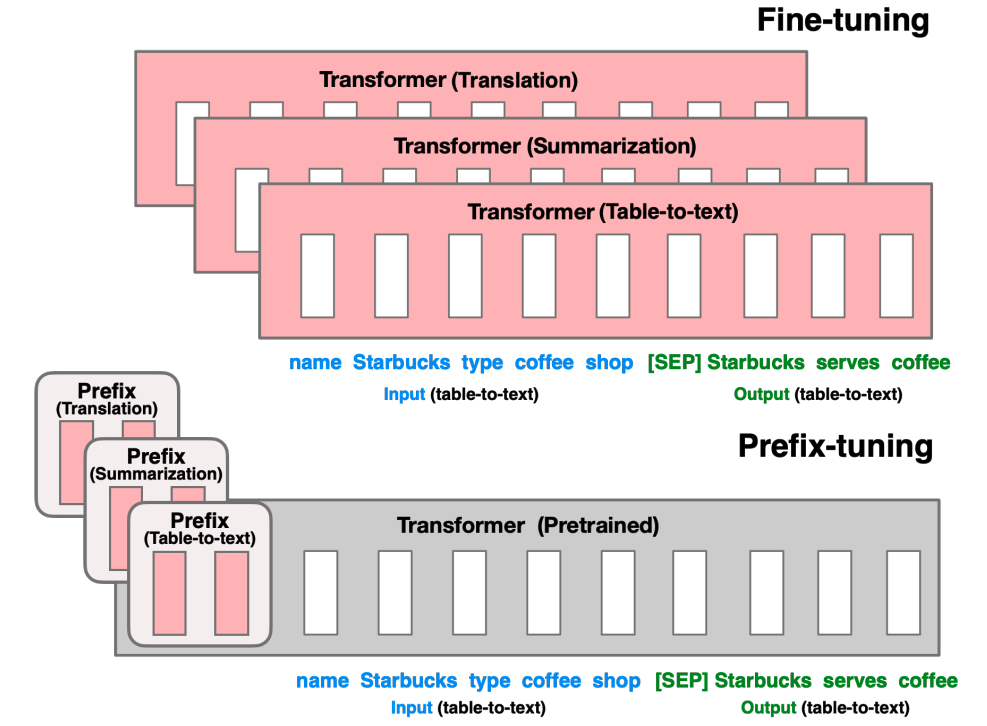

In [ ]:
model_name = 't5-small'

## Step 1: Setting Up the Environment


In [ ]:
%%capture
# Installing the required libraries
!pip install datasets transformers peft

In [ ]:
# Importing the required libraries
import torch
import datasets
from transformers import  T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from peft import get_peft_model, PromptTuningConfig
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import copy

## Step 2: Loading and Tokenizing the Dataset


### Loading and exploring the dataset

In [ ]:
# Loading the dataset
dataset = load_dataset("imdb", split=['train', 'test'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [ ]:
# Getting the label distributions of the dataset
def get_distribution(dataset, key):
  labels, counts = np.unique(dataset[key]['label'], return_counts = True)
  print(f"The distribution of labels in the {key} set is as follows:")
  for label,count in zip(labels,counts):
    print(f"{label} : {count}")
  print()

get_distribution(dataset, 'train')
get_distribution(dataset, 'validation')
get_distribution(dataset, 'test')

The distribution of labels in the train set is as follows:
0 : 10006
1 : 9994

The distribution of labels in the validation set is as follows:
0 : 2494
1 : 2506

The distribution of labels in the test set is as follows:
0 : 12500
1 : 12500



In [ ]:
print(f"The type of the input is: {type(dataset['train'][0]['text'])}")
print(f"The type of the label is: {type(dataset['train'][0]['label'])}")

The type of the input is: <class 'str'>
The type of the label is: <class 'int'>


**We now know that the number of labels in the dataset is 2 and they are of type int.**

### Tokenizing the dataset

In [ ]:
# Loading the tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_name)

In [ ]:
# Performing Tokenization
def tokenization(data):
  # The original dataset contains labels as integers. This is a problem as the T5 models were trained as
  # text to text models. That is, both the inputs and ouputs must be texts.
  labels = ["positive" if label == 1 else "negative" for label in data["label"]]

  ''' The tokenizer used will return a Python dictionary of keys: "input_ids" and "attention_mask".
  The model expects each input to have both of these, one representing the actual tokenized numerical
  representation of the input text and the other a mask indicating which tokens are real vs. padding.
  However, for the labels, the model only expects the token ids and not the mask.
  The inputs are to have a fixed length of 512 tokens, which might require truncation or padding.
  Altough the label is designed to be single token long, I am keeping the max_length of labels at 5
  instead of 1 as tokenization may add addition tokens like <eos> to the already existing ones.
  '''
  sample = tokenizer(data['text'], padding="max_length", truncation=True, max_length=512)
  sample['label'] = tokenizer(labels, padding="max_length", truncation=True, max_length=5).input_ids

  # Deleting the original text of the data sample.
  del(data['text'])
  return sample

# Applying the tokenization function on each split of the dataset bacth wise.
dataset = dataset.map(tokenization,batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### Defining the dataloaders

In [ ]:
from torch.utils.data import DataLoader
'''The dataset currently stores each split data as a Dataset object, which inturn stores
   each item ('input_ids', 'attention_mask' and 'label') as a list of integers. But the DataLoader class
   of PyTorch requires these to be Torch Tensors. Therefore, I am using the below function convert each item
   to a torch tensor as required.
'''
def collate_fn(batch):
    return {
        "input_ids": torch.tensor([sample["input_ids"] for sample in batch], dtype=torch.long),
        "attention_mask": torch.tensor([sample["attention_mask"] for sample in batch], dtype=torch.long),
        "labels": torch.tensor([sample["label"] for sample in batch], dtype=torch.long)
    }

batch_size = 16
train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset["validation"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Step 3: Configuring Soft-Prompt Tuning


In [ ]:
# Loads the T5 Model with 2 labels.
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Config for the Prompt Tuning. Initialises the tokens randomly.
# The below function is referenced from https://huggingface.co/docs/peft/en/task_guides/prompt_based_methods?configurations=prompt+tuning
peft_config = PromptTuningConfig(
    task_type = "SEQ_2_SEQ_LM", # Both inputs and outputs are text.
    num_virtual_tokens=20,
    prompt_tuning_init="RANDOM", # Initialises the virtual tokens randomly.
    token_dim=model.config.d_model,
)

# Wrap the model in a PeftModelForSeq2SeqLM class and automatically freeze the model parameters.
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 20,480 || all params: 60,527,104 || trainable%: 0.0338


## Step 4: Training the Model

The code below is adapted from [this](https://huggingface.co/docs/peft/en/task_guides/prompt_based_methods?configurations=prompt+tuning) page.

In [ ]:
# Function for evaluating the model on validation or test set.
def evaluate_model(peft_model, val_dataloader, device):
  # Defining some required variables.
  val_loss = 0
  val_preds = []
  val_labels = []

  # Change the model to evaluation mode.
  peft_model.eval()
  for step, batch in enumerate(tqdm(val_dataloader)):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = peft_model(**batch)

      loss = outputs.loss
      val_loss += loss.detach().float()

      # Get the predicted and actual labels.
      preds = torch.argmax(outputs.logits, dim=-1)
      labels = batch["labels"]

      # Get the labels ("positive", "negative") back from the tokens ids and append them to the lists.
      val_preds.extend(tokenizer.batch_decode(preds.detach().cpu().numpy(), skip_special_tokens=True))
      val_labels.extend(tokenizer.batch_decode(labels.detach().cpu().numpy(), skip_special_tokens=True))

  return val_preds, val_labels, val_loss

def train_model(peft_model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device):
  # Parameters for early stopping
  best_val_loss = float('inf')
  wait = 0
  best_model_state = None

  for epoch in range(num_epochs):
    train_loss = 0

    # Change the model to train mode.
    peft_model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = peft_model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluating the model on validation data
    val_preds, val_labels, val_loss =  evaluate_model(peft_model, val_dataloader,device)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, val_preds)

    # Calculate loss and perplexity
    val_epoch_loss = val_loss / len(val_dataloader)
    val_ppl = torch.exp(val_epoch_loss)
    train_epoch_loss = train_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # Print the metrics
    print(f"{epoch=}: {train_ppl=:.4f}, {train_epoch_loss=:.4f}, {val_ppl=:.4f}, {val_epoch_loss=:.4f},accuracy={accuracy:.4f}")

    # Checking for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        wait = 0
        best_model_state = copy.deepcopy(peft_model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            break

  # Loading back the best model
  peft_model.load_state_dict(best_model_state)

In [ ]:
# Defining the learning rate, number of epochs, optimizer, patience for early stopping and device.
lr = 3e-2
num_epochs = 15
patience = 5

optimizer = torch.optim.AdamW(peft_model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
peft_model = peft_model.to(device)

# Train the model
train_model(peft_model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device)

  0%|          | 0/1250 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


  0%|          | 0/313 [00:00<?, ?it/s]

epoch=0: train_ppl=3.0720, train_epoch_loss=1.1223, val_ppl=1.1430, val_epoch_loss=0.1337,accuracy=0.5482


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=1: train_ppl=1.2829, train_epoch_loss=0.2491, val_ppl=1.1319, val_epoch_loss=0.1239,accuracy=0.7310


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=2: train_ppl=1.2349, train_epoch_loss=0.2110, val_ppl=1.1244, val_epoch_loss=0.1173,accuracy=0.7150


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=3: train_ppl=1.2029, train_epoch_loss=0.1847, val_ppl=1.1354, val_epoch_loss=0.1270,accuracy=0.5960


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=4: train_ppl=1.1887, train_epoch_loss=0.1729, val_ppl=1.0924, val_epoch_loss=0.0883,accuracy=0.8082


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=5: train_ppl=1.1880, train_epoch_loss=0.1723, val_ppl=1.0843, val_epoch_loss=0.0809,accuracy=0.8342


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=6: train_ppl=1.1809, train_epoch_loss=0.1663, val_ppl=1.0800, val_epoch_loss=0.0770,accuracy=0.8446


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=7: train_ppl=1.1670, train_epoch_loss=0.1544, val_ppl=1.0788, val_epoch_loss=0.0759,accuracy=0.8506


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=8: train_ppl=1.1588, train_epoch_loss=0.1474, val_ppl=1.0698, val_epoch_loss=0.0675,accuracy=0.8644


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=9: train_ppl=1.1662, train_epoch_loss=0.1537, val_ppl=1.0704, val_epoch_loss=0.0680,accuracy=0.8628


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=10: train_ppl=1.1597, train_epoch_loss=0.1482, val_ppl=1.0698, val_epoch_loss=0.0674,accuracy=0.8588


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=11: train_ppl=1.1477, train_epoch_loss=0.1378, val_ppl=1.0749, val_epoch_loss=0.0722,accuracy=0.8396


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=12: train_ppl=1.1482, train_epoch_loss=0.1382, val_ppl=1.0716, val_epoch_loss=0.0692,accuracy=0.8620


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=13: train_ppl=1.1598, train_epoch_loss=0.1482, val_ppl=1.0698, val_epoch_loss=0.0675,accuracy=0.8588


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=14: train_ppl=1.1453, train_epoch_loss=0.1357, val_ppl=1.0731, val_epoch_loss=0.0706,accuracy=0.8414


## Step 5: Evaluation and Analysis

In [ ]:
# Evaluating the model on test data.
test_preds, test_labels, test_loss =  evaluate_model(peft_model, test_dataloader, device)

# Calculate accuracy.
accuracy = accuracy_score(test_labels, test_preds)

# Calulate the loss and perplexity.
test_loss = test_loss / len(test_dataloader)
test_ppl = torch.exp(test_loss)

print(f"{test_ppl=:.4f}, {test_loss=:.4f}, accuracy={accuracy:.4f}")

  0%|          | 0/1563 [00:00<?, ?it/s]

test_ppl=1.0682, test_loss=0.0660, accuracy=0.8590


In [ ]:
# Function to predict the sentiment of texts.
def getSentiment(model,text):
  # Tokenize the input text.
  inputs = tokenizer(text, return_tensors="pt").to(model.device)
  outputs = model.generate(**inputs)

  # Get the labels ("positive", "negative") back from the tokens ids.
  sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True)

  # Print the sentiment.
  print(f"{text} : {sentiment}.")

getSentiment(peft_model,"That movie was excellent.")
getSentiment(peft_model,"That movie was horrible.")
getSentiment(peft_model,"I am loving this ice cream!!")

That movie was excellent. : positive.
That movie was horrible. : negative.
I am loving this ice cream!! : positive.


## **Questions for Analysis** (5+5+5+5+5=25)



**1. What are the advantages of soft-prompt tuning over full fine-tuning in terms of computational efficiency? Can we quantatively show, how much improvement do we obtain in terms of compute?**


---
The advantages of Soft Prompt Tuning over Full Fine Tuning are as follows:
* Reduced Trainable Parameters: Soft prompt tuning works by adding a small set of learnable tokens to the input, while keeping the rest of the model unchanged. Only these added tokens are updated during training. On the other hand, full fine-tuning updates all of the model’s parameters.
* Lower Memory Requirement: Since soft prompt tuning involves updating a small number of parameters, it lowers memory usage during training and inference compared to fine-tuning the entire model. Full fine-tuning requires storing gradients and activations for all the model weights, which increases the memory requirement during training.
* Lower Training Time: Since soft prompt tuning has a smaller set of learnable parameters than full fine tuning, it has lower training time.

We can quantify the improvement we obtain in terms of compute in various ways:

* Percentage of Trainable Parameters: Training time and computational cost are related to the number of trainable parameters. A lower percentage of trainable parameters indicates a more efficient approach. In the example above, the T5-small model has a total of 60,527,104 parameters, but only 20,480 (around 0.0338%) are trainable during soft prompt tuning. In contrast, full fine-tuning involves updating 100% of the parameters.

* Training Time: We can also use the actual time taken to fine-tune the model using each method for comparison. Since soft prompt tuning updates far fewer parameters, it generally requires significantly less training time compared to full fine-tuning.

**2. How does the performance of soft-prompt tuning compare to manually crafted prompts?**


---
Soft prompts typically outperform manually crafted prompts because they are optimized for the specific task during training. Manual prompts on the other hand, rely on human intuition and domain expertise. While manually crafted prompts do not require separate training, they can be time consuming to design and require strong domain knowledge. Additionally, adapting manual prompts to multiple tasks and domains can be challenging as seperate prompts have to be crafted for each one. In contrast, soft prompts can be easily trained for different tasks and domains, making them more flexible and scalable.


**3. What challenges did you encounter while implementing soft-prompt tuning, and how did you address them? Can you come up with a better strategy to improve soft-prompt tuning?**


---
An initial challenge was due to the size of the dataset. Training was only possible on sites like Google Colab or Kaggle due to the model's size. But even with a GPU, training a single epoch was taking too long, and both platforms had limitations on GPU usage. When evaluating the code's functionality, this proved problematic. In order to complete the model code, a small subset of the dataset was chosen, and once the code was complete, the full dataset was used to train the model.


The main challenge arose from using the T5ForSequenceClassification class, which wraps the T5 model with a classification head. Although T5 is inherently a sequence-to-sequence model, this class seemed appropriate for my binary sentiment classification task. However, the issue was that T5ForSequenceClassification expects token IDs as input—not embeddings. Since I’m using soft prompt tuning, which involves prepending trainable embeddings to the input, passing embeddings directly to the model was necessary.

To resolve this, I switched to the T5ForConditionalGeneration class, which accepts input embeddings. This change required some adjustments during preprocessing, as this class generates text outputs instead of numeric class labels. As a result, I converted the original 0/1 labels to the string labels 'negative' and 'positive', and then tokenized them to obtain the target token IDs. During evaluation, the generated tokens also had to be decoded back into text labels to interpret the predictions correctly.

**4. How does the number of soft prompt tokens affect model performance? Can too many or too few prompt tokens degrade performance? What would be the optimal range of tokens to use for soft prompt tuning in the above experiment?**


---

| Num_tokens | Best Val Accuracy | Test Accuracy |
|------------|-------------------|----------------|
| 10         | 0.7308            | 0.7298         |
| 16         | 0.7836            | 0.7825         |
| 20         | 0.8644            | 0.8590         |
| 32         | 0.8680            | 0.8690         |
| 50         | 0.8826            | 0.8863         |
| 64         | 0.8810            | 0.8863         |
| 128        | 0.8874            | 0.8905         |



In soft prompt tuning, the virtual tokens guide the model toward the desired task by injecting task specific information into the input. If the number of tokens is too low, the prompt lacks sufficient capacity to effectively guide the model, leading to suboptimal performance. On the other hand, using too many tokens unnecessarily increases computational cost and may even lead to overfitting. Typically, performance improves as the number of tokens increases, but this improvement tends to saturate beyond a certain point.

Based on the results of the experiment above, the optimal range for the number of virtual tokens appears to be around 30 to 50.

**5. What happens if the soft prompts are initialized with random embeddings versus meaningful embeddings (e.g., derived from task-specific words)?**


---
Initializing soft prompts with random embeddings provides no prior knowledge, meaning the model must learn useful representations entirely from scratch. This can make training slower and less efficient. On the other hand, initializing the prompts with meaningful embeddings gives the model a stronger starting point. These initialized prompts often carry semantic information aligned with the task, which can help guide learning more effectively.

As a result, prompt initialization with meaningful embeddings typically yields at least slightly better performance compared to random initialization.

For example, in the experiment above, using 10 tokens with random initialization resulted in a test accuracy of 0.7298. When tokens were instead initialized using the following task-relevant text:

    "Classify the movie review as having positive or negative sentiment.\n"

the test accuracy increased to 0.7370. Note that the number of tokens in both cases are approximately the same.

# **Part 2: Adapter-Based Fine-Tuning**



## **Objective**
In this you will learn about adapter-based fine-tuning, an efficient technique for adapting large language models to new tasks. Instead of modifying all model parameters, adapter-based fine-tuning inserts small trainable neural networks (adapters) into each layer of the model. Only these adapters are trained, while the main model remains unchanged.

By the end of this part, you will:
- Understand the concept and mathematics behind adapter-based fine-tuning.
- Implement adapter-based fine-tuning using a pretrained transformer model.
- Train the model on a specific task and evaluate its performance.

---

## **1. Introduction to Adapter-Based Fine-Tuning**

### **What is Adapter-Based Fine-Tuning?**
Fine-tuning large models typically requires modifying millions (or even billions) of parameters, which is computationally expensive. Adapter-based fine-tuning offers a more efficient alternative by inserting small **adapter modules** into each layer of the model. During training, only these adapters are updated, while the rest of the model remains frozen.


### **A simple mathematical intuition:**

Let $ x $ be the input sequence and $ f $ be the pretrained model function. The forward pass can be expressed as:
$$
y = f(x)
$$
During fine-tuning with adapters, the forward pass becomes:
$$
y = f(x) + g(x)
$$
where $ g $ is the adapter function.

---

## **2. Steps for Implementing Adapter-Based Fine-Tuning** (100)
Your task is to implement adapter-based fine-tuning in a structured manner. Follow the steps carefully.

### **Step 1: Setting Up the Environment**
- Ensure you have access to a GPU.
- Install required libraries such as `transformers`, `torch`, and `adapter-transformers`.

### **Step 2: Loading and Tokenizing the Dataset**
- Choose a dataset suitable for your task (e.g., imdb).
- Tokenize the dataset using a pretrained tokenizer.
- Define a data loader to process inputs efficiently.

### **Step 3: Configuring Adapter-Based Fine-Tuning**
- Insert adapter layers into the pretrained model.
- Configure the adapter parameters (e.g., size, activation functions).
- Freeze all other model parameters and allow only the adapters to be trainable.

### **Step 4: Training the Model**
- Define a loss function and optimizer.
- Train the model by updating only the adapter parameters.
- Monitor training performance using metrics like accuracy or loss.

### **Step 5: Evaluation and Analysis**
- Evaluate the trained model on a test set.
- Analyze the learned adapter parameters to understand their impact.

---

## **3. Questions for Analysis** (5+5+5+5+5=25)
After completing the experiment, answer the following questions:

1. How does the computational efficiency of adapter-based fine-tuning compare to soft-prompt tuning?
2. What challenges did you face while implementing adapters, and how did you overcome them?
3. How does the size of the adapter module affect performance? Can larger adapters improve results significantly? Can we use adapters that have more number of parameters when compared to original model? What advantage/disadvantage would it add?
4. Could adapter-based fine-tuning be applied to multilingual tasks? What modifications would be required?
5. How would you extend adapter-based fine-tuning to work with multimodal models (e.g., text and image inputs)?





## **Resources**
### **Parameter-Efficient Transfer Learning for NLP**

https://arxiv.org/pdf/1902.00751


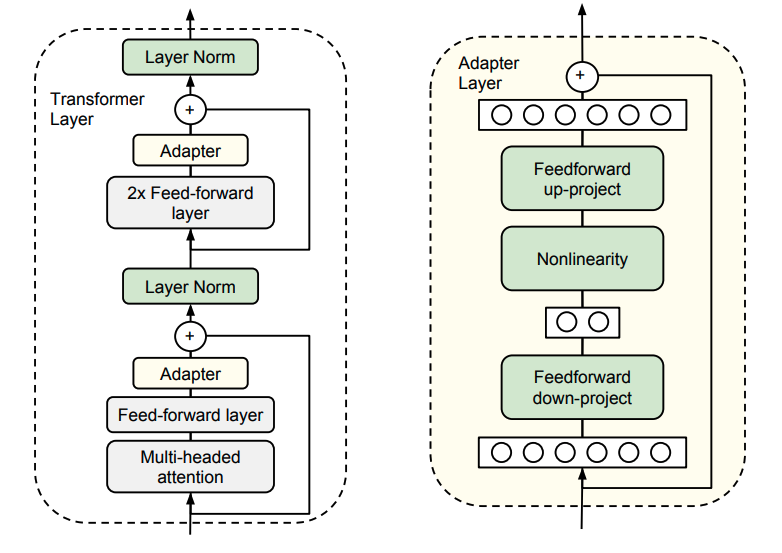

In [ ]:
model_name = 't5-small'

## Step 1: Setting up the Environment

In [ ]:
%%capture
# Installing the required libraries
!pip install datasets adapter-transformers

In [ ]:
# Importing the required libraries
import torch
import datasets
from transformers import  T5Tokenizer, T5ForSequenceClassification
import adapters
from adapters import AdapterConfig, DoubleSeqBnConfig
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import copy

## Step 2: Loading and Tokenizing the Dataset

### Loading and exploring the dataset

In [ ]:
# Loading the dataset
dataset = load_dataset("imdb", split=['train', 'test'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [ ]:
# Getting the label distributions of the dataset
def get_distribution(dataset, key):
  labels, counts = np.unique(dataset[key]['label'], return_counts = True)
  print(f"The distribution of labels in the {key} set is as follows:")
  for label,count in zip(labels,counts):
    print(f"{label} : {count}")
  print()

get_distribution(dataset, 'train')
get_distribution(dataset, 'validation')
get_distribution(dataset, 'test')

The distribution of labels in the train set is as follows:
0 : 10006
1 : 9994

The distribution of labels in the validation set is as follows:
0 : 2494
1 : 2506

The distribution of labels in the test set is as follows:
0 : 12500
1 : 12500



In [ ]:
print(f"The type of the input is: {type(dataset['train'][0]['text'])}")
print(f"The type of the label is: {type(dataset['train'][0]['label'])}")

The type of the input is: <class 'str'>
The type of the label is: <class 'int'>


**We now know that the number of labels in the dataset is 2 and they are of type int.**

### Tokenizing the dataset

In [ ]:
# Loading the Tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_name)

In [ ]:
# Performing Tokenization
def tokenization(data):
  ''' The tokenizer used will return a Python dictionary of keys: "input_ids" and "attention_mask".
  The model expects each input to have both of these, one representing the actual tokenized numerical
  representation of the input text and the other a mask indicating which tokens are real vs. padding.
  The inputs are to have a fixed length of 512 tokens, which might require truncation or padding.
  '''
  sample = tokenizer(data['text'], padding="max_length", truncation=True, max_length=512)

  # For this classification task, labels in the dataset (0 and 1) are used as is.
  sample['label'] = data['label']
  # Deleting the original text of the data sample.
  del(data['text'])
  return sample

# Applying the tokenization function on each split of the dataset bacth wise.
dataset = dataset.map(tokenization,batched=True)

### Defining the dataloaders

In [ ]:
from torch.utils.data import DataLoader
'''The dataset currently stores each split data as a Dataset object, which inturn stores
   each item ('input_ids', 'attention_mask' and 'label') as a list of integers. But the DataLoader class
   of PyTorch requires these to be Torch Tensors. Therefore, I am using the below function convert each item
   to a torch tensor as required.
'''
def collate_fn(batch):
    return {
        "input_ids": torch.tensor([sample["input_ids"] for sample in batch], dtype=torch.long),
        "attention_mask": torch.tensor([sample["attention_mask"] for sample in batch], dtype=torch.long),
        "labels": torch.tensor([sample["label"] for sample in batch], dtype=torch.long)
    }

batch_size = 16
train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset["validation"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Step 3: Configuring Adapter-Based Fine-Tuning

In [ ]:
# Loading the model.
model = T5ForSequenceClassification.from_pretrained(model_name, num_labels = 2)

# Config for Adapter based fine tuning.
# Declaring an identifier for our adapter.
task = 'sentiment_analysis'

# The below function is referenced from https://docs.adapterhub.ml/classes/adapter_config.html#adapters.DoubleSeqBnConfig
# It is the implementaion of the adapter architecture proposed by Houlsby.
adapter_config = DoubleSeqBnConfig(
    reduction_factor=128,
    non_linearity="relu",
)

# The below code is referenced from https://github.com/adapter-hub/adapters
adapters.init(model)
model.add_adapter(task, config=adapter_config)
model.train_adapter(task)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 4: Training the Model

The code below is adapted from [this](https://huggingface.co/docs/peft/en/task_guides/prompt_based_methods?configurations=prompt+tuning) page.

In [ ]:
# Function for evaluating the model on validation or test set.
def evaluate_model(model, val_dataloader, device):
  # Defining some required variables.
  val_loss = 0
  val_preds = []
  val_labels = []

  # Change the model to evaluation mode.
  model.eval()
  for step, batch in enumerate(tqdm(val_dataloader)):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      loss = outputs.loss
      val_loss += loss.detach().float()

      # Get the predicted and actual labels and appends them to the lists.
      preds = torch.argmax(outputs.logits, dim=-1)
      labels = batch["labels"]
      val_preds.extend(preds.detach().cpu().numpy())
      val_labels.extend(labels.detach().cpu().numpy())

  return val_preds, val_labels, val_loss

def train_model(model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device):
  # Parameters for early stopping
  best_val_loss = float('inf')
  wait = 0
  best_model_state = None

  for epoch in range(num_epochs):
    train_loss = 0

    # Change the model to train mode.
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluating the model on validation data
    val_preds, val_labels, val_loss =  evaluate_model(model, val_dataloader,device)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, val_preds)

    # Calculate loss and perplexity
    val_epoch_loss = val_loss / len(val_dataloader)
    val_ppl = torch.exp(val_epoch_loss)
    train_epoch_loss = train_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # Print the metrics
    print(f"{epoch=}: {train_ppl=:.4f}, {train_epoch_loss=:.4f}, {val_ppl=:.4f}, {val_epoch_loss=:.4f},accuracy={accuracy:.4f}")

    # Checking for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        wait = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            break

  # Loading back the best model
  model.load_state_dict(best_model_state)

In [ ]:
# Defining the learning rate, number of epochs, optimizer, patience for early stopping and device.
lr = 3e-4
num_epochs = 10
patience = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train_model(model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=0: train_ppl=1.4169, train_epoch_loss=0.3485, val_ppl=1.2712, val_epoch_loss=0.2400,accuracy=0.9048


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=1: train_ppl=1.2887, train_epoch_loss=0.2537, val_ppl=1.2644, val_epoch_loss=0.2346,accuracy=0.9108


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=2: train_ppl=1.2622, train_epoch_loss=0.2329, val_ppl=1.2403, val_epoch_loss=0.2153,accuracy=0.9138


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=3: train_ppl=1.2473, train_epoch_loss=0.2209, val_ppl=1.2462, val_epoch_loss=0.2201,accuracy=0.9140


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=4: train_ppl=1.2340, train_epoch_loss=0.2102, val_ppl=1.2322, val_epoch_loss=0.2088,accuracy=0.9166


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=5: train_ppl=1.2274, train_epoch_loss=0.2049, val_ppl=1.2460, val_epoch_loss=0.2199,accuracy=0.9166


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=6: train_ppl=1.2170, train_epoch_loss=0.1963, val_ppl=1.2243, val_epoch_loss=0.2024,accuracy=0.9194


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=7: train_ppl=1.2078, train_epoch_loss=0.1888, val_ppl=1.2380, val_epoch_loss=0.2135,accuracy=0.9198


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=8: train_ppl=1.1982, train_epoch_loss=0.1808, val_ppl=1.2303, val_epoch_loss=0.2073,accuracy=0.9208


## Step 5: Evaluation and Analysis

In [ ]:
# Evaluating the model on test data
test_preds, test_labels, test_loss =  evaluate_model(model, test_dataloader, device)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)

# Calculate the loss and perplexity
test_loss = test_loss / len(test_dataloader)
test_ppl = torch.exp(test_loss)

print(f"{test_ppl=:.4f}, {test_loss=:.4f}, accuracy={accuracy:.4f}")

  0%|          | 0/1563 [00:00<?, ?it/s]

test_ppl=1.2178, test_loss=0.1970, accuracy=0.9239


In [ ]:
# Function to predict the sentiment of texts.
def getSentiment(model,text):
  # Tokenize the input text.
  inputs = tokenizer(text, return_tensors="pt").to(model.device)
  outputs = model(**inputs)
  sentiment = torch.argmax(outputs.logits, dim=-1)

  # Convert the predicted sentiment from 0,1 to negative/positive.
  sentiment = "positive" if sentiment==1 else "negative"

  # Print the sentiment.
  print(f"{text} : {sentiment}.")

getSentiment(model,"That movie was excellent.")
getSentiment(model,"That movie was horrible.")
getSentiment(model,"I am loving this ice cream!!")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


That movie was excellent. : positive.
That movie was horrible. : negative.
I am loving this ice cream!! : positive.


## **Questions for Analysis** (5+5+5+5+5=25)



**1. How does the computational efficiency of adapter-based fine-tuning compare to soft-prompt tuning?**


---


Soft prompt tuning is typically more computationally efficient than adapter-based fine-tuning.

In soft prompt tuning, a small set of virtual tokens is prepended to the input text while keeping the rest of the model unchanged. This approach introduces minimal overhead and enables faster training. Also, the number of trainable parameters are independent of the number of transfomer layer or size of the model, only the number of virtual tokens.

Adapter-based fine-tuning involves inserting lightweight adapter modules into each transformer layer. Even though these modules are small, they still add more parameters to the model compared to soft prompt tuning. This incurs higher computational and memory requirements for training. Also, as an adapter is added in each transfomer layer, more such layers mean more adapters and more trainable parameters.

For comparison, soft prompt tuning requires approximately 4.5 minutes per training epoch, whereas adapter-based fine-tuning takes around 9.5 minutes per epoch. However, the latter gives higher accuracy than soft prompt tuning. Thus, there is a trade off between computational/training efficiency and performance.

**2. What challenges did you face while implementing adapters, and how did you overcome them?**


---
The size of the dataset posed a challenge. Training was only possible on sites like Google Colab or Kaggle due to the model's size. But even with a GPU, training a single epoch was taking too long, and both platforms had limitations on GPU usage. When evaluating the code's functionality, this proved problematic. In order to complete the model code, a small subset of the dataset was chosen, and once the code was complete, the full dataset was used to train the model.


**3. How does the size of the adapter module affect performance? Can larger adapters improve results significantly? Can we use adapters that have more number of parameters when compared to original model? What advantage/disadvantage would it add?**


---
| Reduction Factor | Non Linearity | Adapter Size | Best Val Accuracy | Test Accuracy |
|------------------|----------------|---------------|--------------------|----------------|
| 4                | relu           | 128           | 0.9230             | 0.9250         |
| 8                | relu           | 64            | 0.9232             | 0.9272         |
| 16               | relu           | 32            | 0.9198             | 0.9210         |
| 32               | relu           | 16            | 0.9192             | 0.9222         |
| 64               | relu           | 8             | 0.9212             | 0.9235         |
| 128              | relu           | 4             | 0.9208             | 0.9239         |
| 256              | relu           | 2             | 0.9214             | 0.9254         |
|------------------|----------------|---------------|--------------------|----------------|
| 4                | gelu           | 128           | 0.9208             | 0.9232         |
| 8                | gelu           | 64            | 0.9250             | 0.9239         |
| 16               | gelu           | 32            | 0.9218             | 0.9256         |
| 32               | gelu           | 16            | 0.9200             | 0.9212         |
| 64               | gelu           | 8             | 0.9150             | 0.9176         |
| 128              | gelu           | 4             | 0.9192             | 0.9212         |
| 256              | gelu           | 2             | 0.9132             | 0.9184         |
|------------------|----------------|---------------|--------------------|----------------|
| 4                | swish          | 128           | 0.9202             | 0.9233         |
| 8                | swish          | 64            | 0.9226             | 0.9258         |
| 16               | swish          | 32            | 0.9228             | 0.9257         |
| 32               | swish          | 16            | 0.9220             | 0.9243         |
| 64               | swish          | 8             | 0.9086             | 0.9176         |
| 128              | swish          | 4             | 0.9098             | 0.9135         |
| 256              | swish          | 2             | 0.9164             | 0.9183         |



*Note: Adapter Size = d_model/Reduction Factor*

The size of the adapter module affects both the model’s capacity to adapt to new tasks and the amount of additional computation and memory it requires.

If the adapter is too small training will be very fast. But the model might not have the capacity to learn the new task which leads to underfitting.

If the adapter is too large the model can learn better, but will require more time, memory and computation during training. It can also lead to overfitting.

In general, for complex tasks, larger adapters can enhance performance. However, beyond a certain point, the performance gains tend to plateau, making the added computational cost and complexity less worthwhile.


---

It is possible to have adapters that have more parameters than the original model. However, it is generally not common.

Advantages:


*   If the base model is too small and the performance is subpar, we could use a much larger adapter to increase the overall performance.
*   This is useful in cases where we have to keep the base model frozen or share it across different tasks, but still want to improve performance.




Disadvantages:


*   Defeats the main purpose of PEFT; it is no longer efficient.
*   Requires a long time, more compute, and additional memory to train.
*   If the adapter is too large, the frozen base model becomes irrelevant, and the task becomes similar to training a new model from scratch.








**4. Could adapter-based fine-tuning be applied to multilingual tasks? What modifications would be required?**


---
Yes, adapter based fine tuning can be applied to multilingual taks and is actually quite popular.

Modifications:

*   Replace the tokenizer with a multilingual tokenizer.
*   Train seperate adpaters for each language to capture the semantic propoerties of each language. We can easily swap the adapters based on requirement during inference.
*   Can also train a common adapter for all languages to capture properties that are common in languages.
*   The input text could be preprocessed to add language specific tokens to indicate the language of the text.







**5. How would you extend adapter-based fine-tuning to work with multimodal models (e.g., text and image inputs)?**


---

The steps for extending adapter based fine tuning to multimodal models are as follows:

* In multi modal models, it is common to have different types of layers to process different modalities of inputs, like transformers for text ipnuts, CNNs for image inputs etc. First step is to identify these layers.
* Add individual adapters to each modality sepecific layers. This allows the adaptation to be modality specific.
* Adapters can also be applied to layers where the inputs of different modalities are processed together.
* The different adapters can be trained seperately with different reduction factors.


# **Part 3: LoRA (Low-Rank Adaptation) Fine-Tuning**



## **Objective**
In this part you will learn about LoRA (Low-Rank Adaptation), an efficient technique for fine-tuning large language models. Instead of updating all model parameters, LoRA reduces computational costs by approximating weight updates using low-rank matrices. This significantly reduces memory usage while maintaining performance.

By the end of this part, you will:
- Understand the concept and mathematics behind LoRA.
- Implement LoRA fine-tuning using a pretrained transformer model.
- Train the model on a specific task and evaluate its performance.

---

## **1. Introduction to LoRA**

### **What is LoRA (Low-Rank Adaptation)?**
Fine-tuning large models usually requires updating all parameters, leading to high memory and compute requirements. LoRA addresses this by **freezing the pretrained model weights** and learning a small **low-rank decomposition of the weight updates**. This makes fine-tuning more efficient while preserving model performance.

#### A simple mathematical intuition:

Let $ W $ be the weight matrix and $ W' $ be the updated weight matrix. LoRA approximates $ W' $ as:
$$
W^{\prime} - W \approx U V
$$
where $ U $ and $ V $ are low-rank matrices.
---

## **2. Steps for Implementing LoRA Fine-Tuning**           (100)
Your task is to implement LoRA fine-tuning in a structured manner. Follow the steps carefully.

### **Step 1: Setting Up the Environment**
- Ensure you have access to a GPU.
- Install required libraries such as `transformers`, `torch`, and `peft` (Parameter-Efficient Fine-Tuning).

### **Step 2: Loading and Tokenizing the Dataset**
- Choose a dataset suitable for your task (e.g. imbd.).
- Tokenize the dataset using a pretrained tokenizer.
- Define a data loader to process inputs efficiently.

### **Step 3: Configuring LoRA**
- Integrate LoRA into the transformer model using a library like `peft`.
- Define the low-rank matrices **U** and **V**.
- Freeze all other model parameters and allow only LoRA parameters to be trainable.

### **Step 4: Training the Model**
- Define a loss function and optimizer.
- Train the model by updating only the LoRA parameters.
- Monitor training performance using metrics like accuracy or loss.

### **Step 5: Evaluation and Analysis**
- Evaluate the trained model on a test set.
- Analyze the impact of the rank **r** on model performance.

---

## **3. Questions for Analysis** (5+5+5+5+5=25)
After completing the experiment, answer the following questions:
1. How does the memory efficiency of LoRA compare to adapter-based fine-tuning and soft prompts?
2. What challenges did you encounter while implementing LoRA, and how did you overcome them?
3. How does the choice of rank **r** affect the model’s accuracy and computational cost? What would be a suitable measure to choose the optimal rank for a specific task?
4. How does LoRA compare to other parameter-efficient fine-tuning methods like adapters in terms of scalability?
5. How would you extend LoRA to work with multimodal models (e.g., text and image inputs)?









## **Resources**
### LoRA: Low-Rank Adaptation of Large Language Models

LoRA: Low-Rank Adaptation of Large Language Models
https://arxiv.org/pdf/2106.09685
https://github.com/microsoft/LoRA


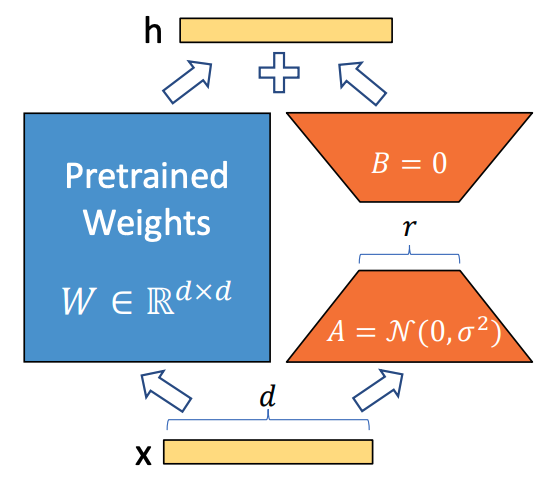

LOW-RANK ADAPTATION OF LARGE LANGUAGE MODEL RESCORING FOR
PARAMETER-EFFICIENT SPEECH RECOGNITION

https://arxiv.org/pdf/2309.15223

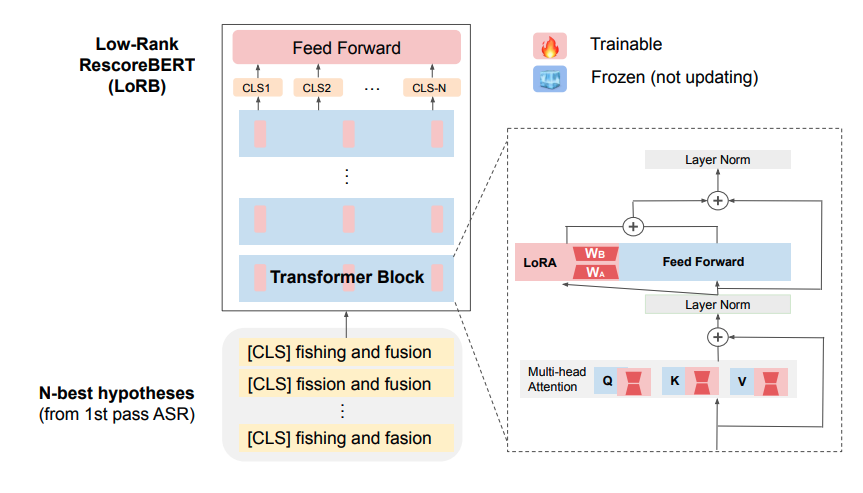

In [ ]:
model_name = 't5-small'

## Step 1: Setting Up the Environment

In [ ]:
%%capture
# Installing the required libraries
!pip install datasets transformers peft

In [ ]:
# Importing the required libraries
import torch
import datasets
from transformers import T5ForSequenceClassification, T5Tokenizer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import copy

## Step 2: Loading and Tokenizing the Dataset

### Loading and exploring the dataset

In [ ]:
# Loading the dataset
dataset = load_dataset("imdb", split=['train', 'test'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [ ]:
# Getting the label distributions of the dataset
def get_distribution(dataset, key):
  labels, counts = np.unique(dataset[key]['label'], return_counts = True)
  print(f"The distribution of labels in the {key} set is as follows:")
  for label,count in zip(labels,counts):
    print(f"{label} : {count}")
  print()

get_distribution(dataset, 'train')
get_distribution(dataset, 'validation')
get_distribution(dataset, 'test')

The distribution of labels in the train set is as follows:
0 : 10006
1 : 9994

The distribution of labels in the validation set is as follows:
0 : 2494
1 : 2506

The distribution of labels in the test set is as follows:
0 : 12500
1 : 12500



In [ ]:
print(f"The type of the input is: {type(dataset['train'][0]['text'])}")
print(f"The type of the label is: {type(dataset['train'][0]['label'])}")

**We now know that the number of labels in the dataset is 2 and they are of type int.**

### Tokenizing the dataset

In [ ]:
# Loading the Tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Performing Tokenization
def tokenization(data):
  ''' The tokenizer used will return a Python dictionary of keys: "input_ids" and "attention_mask".
  The model expects each input to have both of these, one representing the actual tokenized numerical
  representation of the input text and the other a mask indicating which tokens are real vs. padding.
  The inputs are to have a fixed length of 512 tokens, which might require truncation or padding.
  '''
  sample = tokenizer(data['text'], padding="max_length", truncation=True, max_length=512)

  # For this classification task, labels in the dataset (0 and 1) are used as is.
  sample['label'] = data['label']
  # Deleting the original text of the data sample.
  del(data['text'])
  return sample

# Applying the tokenization function on each split of the dataset bacth wise.
dataset = dataset.map(tokenization,batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### Defining the dataloaders

In [ ]:
from torch.utils.data import DataLoader
'''The dataset currently stores each split data as a Dataset object, which inturn stores
   each item ('input_ids', 'attention_mask' and 'label') as a list of integers. But the DataLoader class
   of PyTorch requires these to be Torch Tensors. Therefore, I am using the below function convert each item
   to a torch tensor as required.
'''
def collate_fn(batch):
    return {
        "input_ids": torch.tensor([sample["input_ids"] for sample in batch], dtype=torch.long),
        "attention_mask": torch.tensor([sample["attention_mask"] for sample in batch], dtype=torch.long),
        "labels": torch.tensor([sample["label"] for sample in batch], dtype=torch.long)
    }

batch_size = 16
train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset["validation"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Step 3: Configuring LoRA

In [ ]:
# Loads the model.
model = T5ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define LoRA configuration
# Below  function code is adapted from https://huggingface.co/docs/peft/en/package_reference/lora#peft.LoraModel
peft_config = LoraConfig(
    task_type="SEQ_CLS", # Classification task.
    r=4,  # Rank of LoRA matrices.
    lora_alpha=2,
    target_modules=["q", "v"], # Specifies which modules to apply LoRA to.
    lora_dropout=0.1,
    bias="lora_only", # Updates the bias of LoRA only.
    use_rslora = True
)

# Wrap the model in a PeftModelForSeq2SeqLM class and automatically freeze the model parameters.
peft_model = get_peft_model(model, peft_config)

# Makes the parameters of the classification head trainable.
peft_model.classification_head.dense.weight.requires_grad = True
peft_model.classification_head.dense.bias.requires_grad = True
peft_model.classification_head.out_proj.weight.requires_grad = True
peft_model.classification_head.out_proj.bias.requires_grad = True

peft_model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 411,138 || all params: 60,917,762 || trainable%: 0.6749


## Step 4: Training the Model

The code below is adapted from [this](https://huggingface.co/docs/peft/en/task_guides/prompt_based_methods?configurations=prompt+tuning) page.

In [ ]:
# Function for evaluating the model on validation or test set.
def evaluate_model(peft_model, val_dataloader, device):
  # Defining some required variables.
  val_loss = 0
  val_preds = []
  val_labels = []

  # Change the model to evaluation mode.
  peft_model.eval()
  for step, batch in enumerate(tqdm(val_dataloader)):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = peft_model(**batch)

      loss = outputs.loss
      val_loss += loss.detach().float()

      # Get the predicted and actual labels and appends them to the list.
      preds = torch.argmax(outputs.logits, dim=-1)
      labels = batch["labels"]
      val_preds.extend(preds.detach().cpu().numpy())
      val_labels.extend(labels.detach().cpu().numpy())

  return val_preds, val_labels, val_loss

def train_model(peft_model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device):
  # Parameters for early stopping
  best_val_loss = float('inf')
  wait = 0
  best_model_state = None

  for epoch in range(num_epochs):
    train_loss = 0

    # Change the model to train mode.
    peft_model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = peft_model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluating the model on validation data
    val_preds, val_labels, val_loss =  evaluate_model(peft_model, val_dataloader,device)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, val_preds)

    # Calculate loss and perplexity
    val_epoch_loss = val_loss / len(val_dataloader)
    val_ppl = torch.exp(val_epoch_loss)
    train_epoch_loss = train_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # Print the metrics
    print(f"{epoch=}: {train_ppl=:.4f}, {train_epoch_loss=:.4f}, {val_ppl=:.4f}, {val_epoch_loss=:.4f},accuracy={accuracy:.4f}")

    # Checking for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        wait = 0
        best_model_state = copy.deepcopy(peft_model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            break

  # Loading back the best model
  peft_model.load_state_dict(best_model_state)

In [ ]:
# Defining the learning rate, number of epochs, optimizer, patience for early stopping and device.
lr = 3e-4
num_epochs = 10
patience = 2
optimizer = torch.optim.AdamW(peft_model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = peft_model.to(device)

# Train the model
train_model(peft_model, num_epochs, train_dataloader, val_dataloader, optimizer, patience, device)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=0: train_ppl=1.4279, train_epoch_loss=0.3562, val_ppl=1.2919, val_epoch_loss=0.2561,accuracy=0.8988


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=1: train_ppl=1.2917, train_epoch_loss=0.2560, val_ppl=1.2665, val_epoch_loss=0.2362,accuracy=0.9052


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=2: train_ppl=1.2645, train_epoch_loss=0.2347, val_ppl=1.2525, val_epoch_loss=0.2251,accuracy=0.9102


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=3: train_ppl=1.2494, train_epoch_loss=0.2227, val_ppl=1.2473, val_epoch_loss=0.2210,accuracy=0.9162


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=4: train_ppl=1.2347, train_epoch_loss=0.2109, val_ppl=1.2382, val_epoch_loss=0.2136,accuracy=0.9176


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=5: train_ppl=1.2258, train_epoch_loss=0.2036, val_ppl=1.2467, val_epoch_loss=0.2205,accuracy=0.9174


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch=6: train_ppl=1.2181, train_epoch_loss=0.1973, val_ppl=1.2554, val_epoch_loss=0.2274,accuracy=0.9142


## Step 5: Evaluation and Analysis

In [ ]:
# Evaluating the model on test data
test_preds, test_labels, test_loss =  evaluate_model(peft_model, test_dataloader, device)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)

# Calculate loss and perplexity
test_loss = test_loss / len(test_dataloader)
test_ppl = torch.exp(test_loss)

print(f"{test_ppl=:.4f}, {test_loss=:.4f}, accuracy={accuracy:.4f}")


  0%|          | 0/1563 [00:00<?, ?it/s]

test_ppl=1.2252, test_loss=0.2031, accuracy=0.9192


In [ ]:
# Function to predict the sentiment of texts.
def getSentiment(model,text):
  # Tokenize the input text.
  inputs = tokenizer(text, return_tensors="pt").to(model.device)
  outputs = model(**inputs)
  sentiment = torch.argmax(outputs.logits, dim=-1)

  # Convert the predicted sentiment from 0,1 to negative/positive.
  sentiment = "positive" if sentiment==1 else "negative"

  # Print the sentiment.
  print(f"{text} : {sentiment}.")

getSentiment(peft_model,"That movie was excellent.")
getSentiment(peft_model,"That movie was horrible.")
getSentiment(peft_model,"I am loving this ice cream!!")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


That movie was excellent. : positive.
That movie was horrible. : negative.
I am loving this ice cream!! : positive.


## **Questions for Analysis** (5+5+5+5+5=25)



**1. How does the memory efficiency of LoRA compare to adapter-based fine-tuning and soft prompts?**


---

LoRA is more memmory efficient than adapter based fine tuning but is less efficient than soft prompt fine tuning.

Soft prompt fine-tuning involves only a small set of trainable tokens that are prepended to the text input. The base model is kept frozen. The number of learnable parameters is very small, and hence this approach has the lowest memory requirement. This number is independent of the number of transformer layers (size) of the model.

Adapter based fine tuning on the other hand adds small trainable modules (typically MLP) to the model, which generally adds more parameters than soft prompting and hence has more memmory requirement. The number also increases with increase in number of transformer layers.

LoRA on the other hand uses low rank matrices for updating weight matrices. Only these low rank matrix is trained, keeping the original model frozen. Even though the number of trainable parameters involved does increase with the number of transformer layers, since we are only using low rank matrices rather than full feedforward layers, the overall rate of growth is much smaller than adapter based case. Additionally, unlike the adapter based case, there is no extra activations. Hence the overall memmory effiency is much better than adapter based case.


**2. What challenges did you encounter while implementing LoRA, and how did you overcome them?**


---
An initial challenge arose due to the large size of the dataset. Given the size of the model, training could only be conducted on platforms like Google Colab or Kaggle. However, both platforms have GPU usage restrictions, and even with a GPU, training a single epoch was taking too long. This became an issue when testing the functionality of the code. The solution was to select a small subset of the dataset to finalize the model code, and then train the model with the entire dataset once the code was ready.

The main challenge was understanding why the model consistently produced around 50% accuracy across all training epochs. The issue was due to PEFT automatically freezing all the weights of the base model. In my case, the base model was a T5 model with an added classification head. Since the weights and biases of this head were uninitialized, they needed to be trained—but PEFT had frozen them as well. The solution was to modify the PEFT model to ensure that all parameters of the classification head were set as trainable.

**3. How does the choice of rank *r* affect the model’s accuracy and computational cost? What would be a suitable measure to choose the optimal rank for a specific task?**


---
| r  | lora_alpha | Best Val Accuracy | Test Accuracy |
|----|------------|-------------------|---------------|
| 2  | 2          | 0.9216            | 0.9240        |
| 2  | 4          | 0.9250            | 0.9240        |
| 2  | 8          | 0.9214            | 0.9244        |
|----|------------|-------------------|---------------|
| 4  | 2          | 0.9176            | 0.9192        |
| 4  | 4          | 0.9236            | 0.9238        |
| 4  | 8          | 0.9202            | 0.9223        |
| 4  | 16         | 0.9212            | 0.9226        |
|----|------------|-------------------|---------------|
| 8  | 4          | 0.9226            | 0.9245        |
| 8  | 8          | 0.9206            | 0.9218        |
| 8  | 16         | 0.9234            | 0.9204        |
| 8  | 32         | 0.9220            | 0.9231        |
|----|------------|-------------------|---------------|
| 16 | 8          | 0.9202            | 0.9203        |
| 16 | 16         | 0.9228            | 0.9254        |
| 16 | 32         | 0.9246            | 0.9228        |
| 16 | 64         | 0.9124            | 0.9170        |


Note
$$
W' = W + \frac{\alpha}{\sqrt{r}}\,(B \cdot A)
$$

Where:
- \(W\) is the original weight matrix  
- \(W'\) is the updated weight matrix  
- \(alpha\) is the LoRA scaling factor  
- \(r\) is the rank of the low‑rank update  
- \(A\) and \(B\) are the low‑rank adaptation matrices
- I am using rank stabalized LoRA, which is why the r value in the denominator is under sqrt. According to the PEFT LoRA webpage, it has been shown to give better results.

Lower values of *r* mean fewer trainable parameters in the model, which reduces computational cost and memory requirements, leading to faster training times. However, with fewer parameters, the model may not be able to learn accurate approximations, potentially reducing its accuracy and increasing the risk of underfitting.

On the other hand, higher values of *r* increase the number of trainable parameters, resulting in higher memory and computational requirements during training, thus leading to longer training times. For more complex tasks, a larger *r* allows the model to learn better approximations, improving accuracy. However, this also raises the likelihood of overfitting.




---

There are several approaches to selecting the optimal *r* value:

* Task-specific heuristics: For simple tasks such as classification, smaller values of *r* (e.g., 2-8) could be used. For more complex tasks, like summarization, which require capturing long-range dependencies, larger values (e.g., 16-32) could be used.

* Grid search: This involves training the model with multiple *r* values (e.g., 2, 4, 8, 16, etc.) and selecting the model that achieves the best validation accuracy.






**4. How does LoRA compare to other parameter-efficient fine-tuning methods like adapters in terms of scalability?**


---
Soft prompt tuning is highly scalable to larger models because it only requires training a small set of prompt embeddings. The underlying model remains unchanged, and the number of additional tokens stays constant regardless of model size. This approach also adapts well to multitask settings, as different prompt tokens can be trained for each task and easily interchanged during inference. It is particularly effective for tasks involving text data.

Adapter-based fine-tuning also offers good scalability, but it's not as efficient for larger models compared to soft prompt tuning. This is because adapter modules need to be inserted into every transformer layer, leading to increased memory usage and computational overhead as the model size and depth grow. Inference time is slightly lower than the base model due to the added modules. This overhead increases with increase in model size. However, it scales effectively across different tasks, as task-specific adapters can be trained and swapped in as needed. The same approach extends well to multimodal tasks.

LoRA scales well to large models as it only learns two low-rank matrices for each weight matrix. Although the number of such matrices increases with model size, their low-rank nature makes it more memory and compute efficient compared to adapter based methods. Additionally, it does not require separate activation functions. LoRA also extends well to multitask and multimodal scenarios by training task-specific low-rank matrices that can be easily swapped during inference.


**5. How would you extend LoRA to work with multimodal models (e.g., text and image inputs)?**


---

The steps for extending LoRA to multimodal models are as follows:

* In multi modal models, it is common to have different types of layers to process different modalities of inputs, like transformers for text ipnuts, CNNs for image inputs etc. First step is to identify these layers.
* Apply LoRA seprately to each modality sepecific layers. This allows the adaptation to be modality specific and LoRA can learn the required low rank modifications for each modality independently.
* LoRA can also be applied to layers where the inputs of different modalities are processed together.
* LoRA rank for different modalities can also be tuned seperately for optimal performance.

# **Part 4: Additional Question  (25)**

**Apart from Soft-Prompt Tuning, Adapter-Based Fine-Tuning, and LoRA, explore all other Parameter-Efficient Fine-Tuning (PEFT) approaches. For each approach, provide a detailed explanation along with its mathematical formulation. Compare their practical trade-offs in terms of memory usage, computational efficiency, and adaptability.**

---

**1. Infused Adapter by Inhibiting and Amplifying Inner Activations (IA3)**


IA³ operates by scaling the existing keys and values in the attention layers, as well as the outputs of the feed-forward layers, using learnable scaling vectors. These scaling vectors are the only parameters trained, while the rest of the model remains frozen.

The normal attention mechanism in transformers is given below.
$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V
$$
IA³ modifies the attention mechanism to the following
$$
\text{Attention}(Q, K', V') = \text{softmax}\left( \frac{Q \left( \ell_K \odot K \right)^T}{\sqrt{d_k}} \right) \left( \ell_V \odot V \right)
$$
where $\odot$ denotes element-wise multiplication.\
$\ell_K, \ell_V \in \mathbb{R}^d$ (where $d$ is the hidden dimension)


Additionally, IA³ modifies the output of the feed-forward layers as follows:
$$
\text{FFN}'(x) = \ell_{\text{FFN}} \odot \text{FFN}(x)
$$
where $\ell_{\text{FFN}} \in \mathbb{R}^{d_{\text{FFN}}}$

This method introduces only a small number of parameters (three scaling vectors per layer) resulting in minimal memory overhead. The overhead is further reduced since it doesn't require adding large matrices, layers, or modules. While its adaptability is somewhat limited due to only rescaling existing components, it can be efficiently extended to multiple tasks by training task-specific scaling vectors and swapping them in as needed.



---
**2. BitFit: Bias Only Fine Tuning**

BitFit keeps the weights of all attention and feedforward layers fixed, training only the bias terms of each layer. This method does not introduce any new parameters but instead updates the existing bias parameters. Since the number of biases in the model is relatively small, this approach is memory-efficient. While its adaptability is limited due to only updating the biases, it can still be effective for certain tasks.

---
**3. Prefix Tuning**

Prefix tuning works by prepending a small number of learnable vectors (prefixes) to each Transformer layer’s key and value projections. Only these vectors are trained and the rest of the model is kept frozen.

The key and value projections are modified as follows:

$K' = [K_p \, ; \, K] \quad \text{and} \quad V' = [V_p \, ; \, V]$

Where:

- $K_p, V_p \in \mathbb{R}^{l_p \times d}$ are the learnable prefix key/value vectors (with prefix length $l_p$),

- $K, V \in \mathbb{R}^{l \times d}$ are the standard key/value projections from the input sequence.

This technique has low memory requirements because it involves only a small number of trainable parameters. Since the majority of the model remains frozen, there's no need to store gradients or optimizer states for those parts, making training faster as well. However, because prefix vectors are added to every transformer layer, memory usage still scales with the number of layers. It has good adaptability as different prefixes can be trained for different tasks or domains and easily swapped in as needed.

---

**4. AdaMix**

The idea is mix to mix multiple adapters for a given task instead of just using a single adapter. It combines multiple adapters, each trained for a different task or domain, in a task-specific fusion layer. Can be easily extended to multiple domains or tasks.




**Among all the discussed methods, including Soft-Prompt Tuning, Adapter-Based Fine-Tuning, and LoRA, which one do you think is the most suitable for a multilingual text classification task with limited training data? Justify your answer by comparing the trade-offs of at least two methods, considering real-world constraints such as hardware limitations and data availability.**

---
Given the hardware and data limitations, LoRA would be my preferred choice for the task.

LoRA is well-suited for low-resource settings. Since we are only training a small number of parameters, the risk of overfitting on limited datasets is reduced. Additionally, separate low-rank matrices can be trained for different languages. The low memory and compute requirements further make it a practical choice.

BitFit, which involves updating only the bias terms, is attractive for its extremely low computational cost and minimal data needs. However, this also restricts the models ability to learn and adapt, making it less effective for complex tasks such as multilingual text classification.

Soft prompt tuning is another parameter-efficient method with few trainable parameters, making it a good fit for resource-constrained environments. It generally performs reasonably well even on small datasets. However, its performance tends to be slightly lower than LoRA, especially on more complex tasks.